# Градиентные методы

In [33]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

random_seed = 43

## Линейная регрессия

Сгенерируем матрицы признаков $X$ и правильного вектора весов $w_{true}$. Вектор цели (или матрица в общем случае) $Y$ вычисляется как $X\mathbf{w}_{\text{true}}$ с гауссовым шумом:

In [34]:
n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43
np.random.seed(random_seed)

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))

X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :] 

Y = X.dot(w_true) + np.random.normal(0, 1, n_objects)

*Напоминание:*

В случае линейной модели
$$
\hat{\mathbf{y}} = \tilde{X} \mathbf{w}
$$
и функции потерь **MSE**
$$
\mathcal{L}(\mathbf{y}, \tilde{X}, \mathbf{w}) = MSE(\mathbf{y}, \tilde{X}, \mathbf{w}) = \|\mathbf{y} - \tilde{X}\mathbf{w}\|^2_2 = \sum_i (y_i - \mathbf{x}^{\top}_i \mathbf{w})^2
$$
аналитическое решение принимает простую форму:

$$
\tilde{\mathbf{w}} = (\tilde{X}^\top \tilde{X})^{-1} \tilde{X}^\top \mathbf{y}.
$$

Давайте проверим, как это работает:

In [35]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
w_star

array([ 0.22949708, -0.89901869])

In [36]:
w_true

array([ 0.25739993, -0.90848143])

Как видим, аналитическое решение довольно близко к исходному.

Теперь давайте сгенерируем набор данных с коррелированными признаками:

In [37]:
n_features = 3
n_objects = 300
batch_size = 10
num_steps = 43
eps = 1e-3

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))

X[:, -1] = X[:, -2] + np.random.uniform(-eps, eps, X[:, -2].shape)

Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))

In [38]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
w_star

array([  -1.00903341, -211.9915962 ,  210.3684149 ])

In [39]:
w_true

array([-1.00272558, -0.76590424, -0.85821489])

Как мы видим, второй и третий коэффициенты найдены неверно. Практически это означает, что модель является *нестабильной*.

Это можно исправить с помощью **регуляризации**.

Давайте используем норму L2 вектора весов как член регуляризации, чтобы ограничить желаемое решение.

$$
\mathcal{L}_{\text{reg}}(\mathbf{y}, \tilde{X}, \mathbf{w}) = MSE(\mathbf{y}, \tilde{X}, \mathbf{w}) + \lambda\|\mathbf{w}\|_2^2
= \|\mathbf{y} - \tilde{X}\mathbf{w}\|_2^2 + \lambda\|\mathbf{w}\|_2^2
= \sum_i \Bigl(y_i - \mathbf{x}_i^\top\mathbf{w}\Bigr)^2 + \lambda\sum_{j}w_j^2.
$$



В этом случае также доступно аналитическое решение:

$$
\tilde{\mathbf{w}}_{\text{reg}} = (X^\top X + \lambda I_p)^{-1}X^\top Y,
$$
где $I_p$ — диагональная матрица, состоящая из единиц (размера p).

**Будьте внимательны с членом регуляризации**

Если вы включили столбец единиц в матрицу X, поскольку регуляризировать член смещения (свободный) в линейной модели не нужно.

In [42]:
w_star_reg = np.linalg.inv(X.T.dot(X) 
                           + 0.02*np.eye(n_features)).dot(X.T).dot(Y)
w_star_reg

array([-1.01028374, -1.32047258, -0.2996804 ])

In [43]:
w_true

array([-1.00272558, -0.76590424, -0.85821489])

## Градиентный спуск

Аналитическое решение, описанное выше, включает в себя обращение матрицы $X^\top X$ (или $X^\top X + \lambda I$), что довольно затратно с точки зрения вычислительных ресурсов. Сложность обращения матрицы можно оценить как $O(p^3 + p^2 N)$ ($p$ - размерность вектора признаков). 

Это приводит к тому, что на практике пользуются итеративным методам оптимизации, которые более эффективны и, фактически, являются основным подходом к оптимизации в машинном обучении.

Градиентный спуск является одним из самых популярных методов оптимизации и включает с себя целое семейство методов. 

Стоит отметить, что цель минимизации (в частности, значение функции потерь) должна быть **дифференцируемой** относительно параметров модели. Используя градиентный спуск, вектор весов $\tilde{\mathbf{w}}^{(t+1)}$ на шаге $t+1$ можно выразить в следующем виде:
$$
\tilde{\mathbf{w}}^{(t+1)} = \tilde{\mathbf{w}}^{(t)} - ​​\eta_t \nabla \mathcal{L}(\tilde{\mathbf{w}}^{(t)}),
$$
где $\eta_t$ является шагом градиентного спуска (иногда его еще называют скоростью обучения).

Градиент в случае функции потерь MSE принимает следующий вид:

$$
\nabla \mathcal{L}(\mathbf{w}) = -2X^\top \mathbf{y} + 2X^\top X\mathbf{w} = 2X^\top (X \tilde{\mathbf{w}} - \mathbf{y}).
$$

В этом случае сложность составляет $O(pN)$. 

Чтобы сделать градиентный спуск еще более эффективным можно использовать гипотезу об однородных данных, переходя к стохастическому градиентному спуску, который вычисляет градиент только по некоторому случайному подмножеству точек данных, поэтому окончательная сложность уменьшается до $O(pK)$, где $K << N$.

In [123]:
def visualize_descent(w_history, 
                      X, Y, 
                      w_true=None, 
                      title='Trajectory', 
                      margin=0.1, 
                      contour_levels=np.logspace(0, 2, 40)):
    w1_min = w_history[:, 0].min() - margin
    w1_max = w_history[:, 0].max() + margin
    w2_min = w_history[:, 1].min() - margin
    w2_max = w_history[:, 1].max() + margin

    A, B = np.meshgrid(np.linspace(w1_min, w1_max, 100),
                       np.linspace(w2_min, w2_max, 100))
    
    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = np.mean((np.dot(X, w_tmp) - Y)**2)
    
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim(w1_min, w1_max)
    plt.ylim(w2_min, w2_max)
    plt.gca().set_aspect('equal')
    
    CS = plt.contour(A, B, levels, levels=contour_levels, cmap=plt.cm.rainbow_r)
    plt.colorbar(CS, shrink=0.8, extend='both')
    
    if w_true is not None:
        plt.scatter(w_true[0], w_true[1], c='r', label='True weights')
    plt.scatter(w_history[:, 0], w_history[:, 1], label='Descent points')
    plt.plot(w_history[:, 0], w_history[:, 1], label='Trajectory')
    
    plt.legend()
    plt.show()

### Визуализация траектории градиентного спуска

Давайте внимательно рассмотрим путь оптимизации в простом двумерном пространстве (где признаки находятся в разных масштабах). Будем использовать функцию потерь MSE.

Графики ниже показывают значения $\tilde{\mathbf{w}}^{(t)}$ на каждом шаге $t$. Красная точка в является конечной для $\tilde{\mathbf{w}}$.

In [159]:
n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43
np.random.seed(random_seed)

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))

X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :] 

Y = X.dot(w_true) + np.random.normal(0, 1, n_objects)

In [135]:
np.random.seed(random_seed)
w_0 = np.random.uniform(-2, 2, n_features)-0.5
w = w_0.copy()
w_list = [w.copy()]
step_size = 1e-2

for i in range(num_steps):
    w -= step_size * 2. * np.dot(X.T, (X.dot(w) - Y)) / Y.size
    w_list.append(w.copy())
w_list = np.array(w_list)

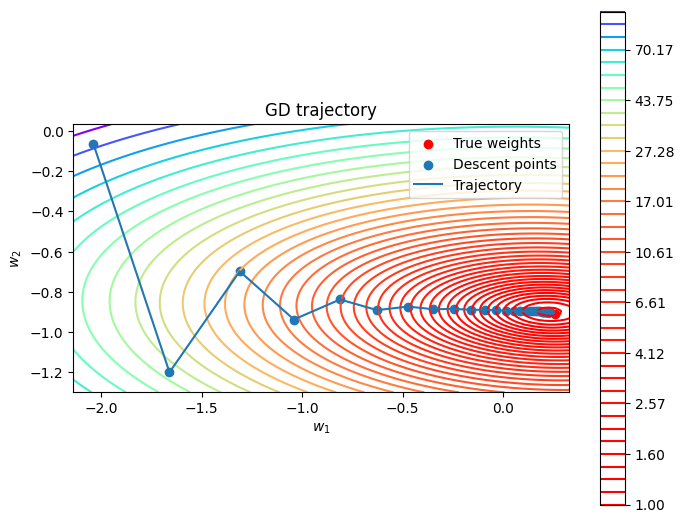

In [136]:
visualize_descent(w_list, X, Y, 
                  w_true=w_true, 
                  title='GD trajectory')

Вектор градиента ортогонален эквипотенциальной поверхности (линиям уровня). Вот почему путь оптимизации не такой гладкий. 

Давайте визуализируем направления градиента, для большей наглядности.

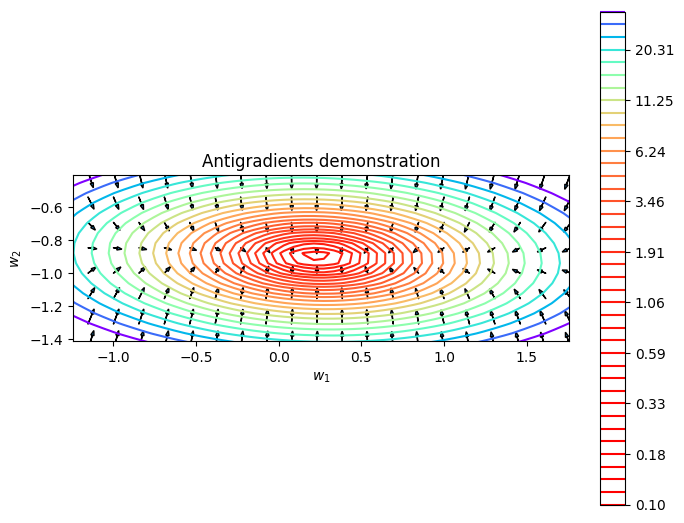

In [137]:
A, B = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
A_mini, B_mini = np.meshgrid(np.linspace(-3, 3, 40), np.linspace(-3, 3, 40))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))
        
plt.figure(figsize=(8, 8))
CS = plt.contour(A, B, levels, 
                 levels=np.logspace(-1, 1.5, num=40), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
        
gradients = np.empty_like(A_mini)
for i in range(A_mini.shape[0]):
    for j in range(A_mini.shape[1]):
        w_tmp = np.array([A_mini[i, j], B_mini[i, j]])
        antigrad = - 2 * 1e-3 * np.dot(X.T, np.dot(X, w_tmp) - Y) / Y.shape[0]
        plt.arrow(A_mini[i, j], B_mini[i, j], 
                  antigrad[0], antigrad[1], head_width=0.02)

plt.title('Antigradients demonstration')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_true[0] - 1.5, w_true[0] + 1.5))
plt.ylim((w_true[1] - .5, w_true[1] + .5))
plt.gca().set_aspect('equal')
plt.show()

Теперь давайте взглянем на стохастический градиентный спуск. 

Пусть число элементов, вычисляемых функцией потерь для каждого состояния (`batch_size`), будет равно $10$.

In [138]:
np.random.seed(random_seed)
batch_size = 10
w = w_0.copy()
w_history_list = [w.copy()]
lr = 1e-2

for i in range(2*num_steps):
    sample_indices = np.random.randint(0, n_objects, batch_size)
    X_batch = X[sample_indices, :]
    Y_batch = Y[sample_indices]
    w -= 2 * lr * np.dot(X_batch.T, X_batch @ w - Y_batch) / batch_size
    w_history_list.append(w.copy())
w_history_list = np.array(w_history_list)

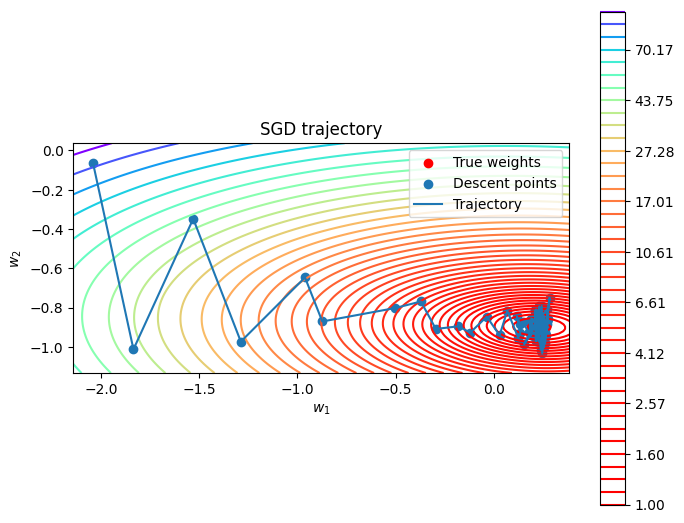

In [139]:
visualize_descent(w_history_list, X, Y, 
                  w_true=w_true,
                  title='SGD trajectory')

Как видно из графика, SGD «блуждает» вокруг оптимумов. 

Это контролируется размером шага SGD $\eta_k$, а сходимость в общем случае не гарантируется. Для сходимости метода SGD при заданной последовательности шагов $\{\eta_k\}$ необходимо, чтобы выполнялись [условия Роббинса-Монро](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177729586):
$$
\sum_{k = 1}^\infty \eta_k = \infty, \qquad \sum_{k = 1}^\infty \eta_k^2 < \infty.
$$
Более интуитивно эти условия можно объяснить следующим образом:
1. Последовательность шагов $\{\eta_k\}$ должна расходиться, чтобы метод оптимизации мог достичь любой точки в заданном пространстве параметров,
2. В то же время она должна расходиться «не так быстро»

Проанализируем траектории SGD, которые генерируются последовательностью шагов, удовлетворяющих условиям Роббинса-Монро:

In [140]:
np.random.seed(random_seed)
w = w_0.copy()
w_list = [w.copy()]
lr_0 = 1e-2

for i in range(num_steps):
    lr = lr_0 / ((i+1) ** 0.5005)
    sample_indices = np.random.randint(0, n_objects, batch_size)
    X_batch = X[sample_indices, :]
    Y_batch = Y[sample_indices]
    w -= 2 * lr * np.dot(X_batch.T, X_batch @ w - Y_batch) / batch_size

    w_list.append(w.copy())
w_list = np.array(w_list)

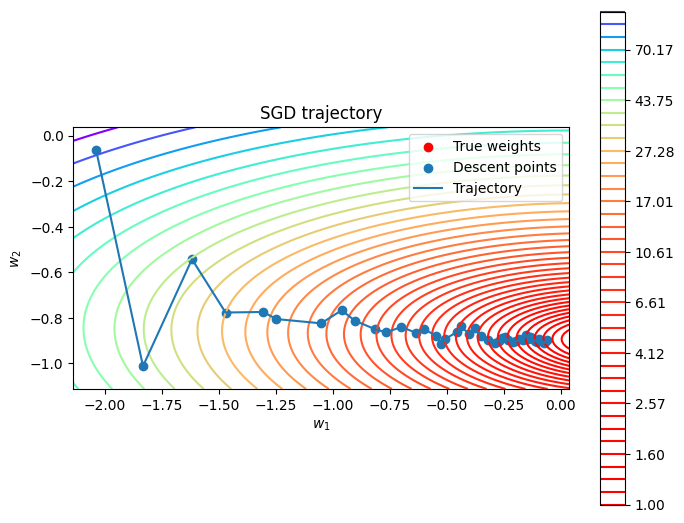

In [141]:
visualize_descent(w_list, X, Y, 
                  w_true=w_true,
                  title='SGD trajectory')

Еще один подход - градиентный спуск с импульсом (Momentum)

Метод импульса помогает ускорить сходимость и смягчить колебания, добавляя "инерцию" к обновлениям:
$$
\mathbf{v}^{(t+1)} = \gamma \mathbf{v}^{(t)} + \eta \nabla \mathcal{L}(\tilde{\mathbf{w}}^{(t)}),
$$

$$
\tilde{\mathbf{w}}^{(t+1)} = \tilde{\mathbf{w}}^{(t)} - \mathbf{v}^{(t+1)},
$$
где:
- $\mathbf{v}^{(t)}$ — накопленный градиент (скорость),
- $\gamma$ — коэффициент импульса (обычно от 0.8 до 0.99).

In [146]:
np.random.seed(random_seed)
w = w_0.copy()
w_list = [w.copy()]
lr_0 = 1e-2
gamma = 0.6
v = np.zeros_like(w)

for i in range(num_steps):
    grad = 2 * np.dot(X.T, (np.dot(X, w) - Y)) / n_objects
    v = gamma * v + lr * grad
    w -= v
    w_list.append(w.copy())

w_list = np.array(w_list)

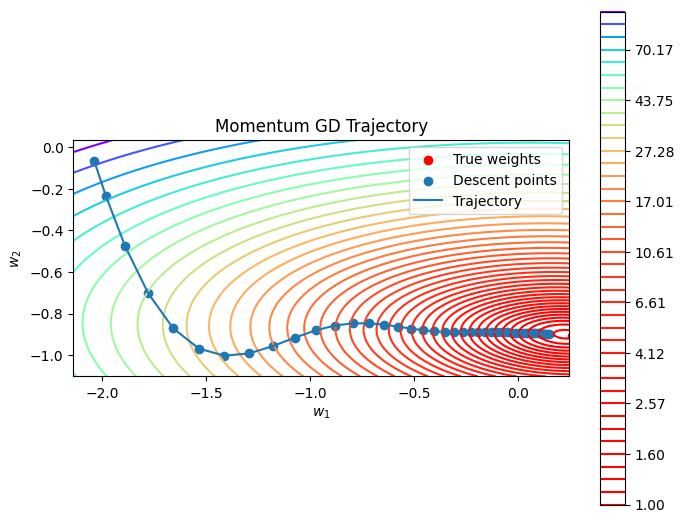

In [147]:
visualize_descent(w_list, X, Y, 
                  w_true=w_true,
                  title='Momentum GD Trajectory')

### AdaGrad

**Идея:** Метод AdaGrad корректирует скорость обучения для каждого параметра в зависимости от суммы квадратов предыдущих градиентов. Это позволяет уменьшать шаги по направлениям, где градиенты были большими, и сохранять более высокие шаги там, где градиенты малы.

Пусть $ g_t $ — градиент на шаге $ t $. Тогда суммарное накопление квадратов градиентов:
$$
G_t = \sum_{i=1}^t g_i^2.
$$
Обновление параметров:
$$
w_{t+1} = w_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \circ g_t,
$$
где:
- $\eta$ — базовая скорость обучения,
- $\epsilon$ — небольшая константа для избежания деления на ноль,
- $\circ$ обозначает поэлементное деление.


In [170]:
np.random.seed(random_seed)
w = w_0.copy()
w_list = [w.copy()]
lr = 0.5
epsilon = 1e-8
accum = np.zeros_like(w)

for t in range(num_steps):
    grad = 2 * np.dot(X.T, (np.dot(X, w) - Y)) / n_objects
    accum += grad**2
    w -= lr * grad / (np.sqrt(accum) + epsilon)
    w_list.append(w.copy())

w_list = np.array(w_list)

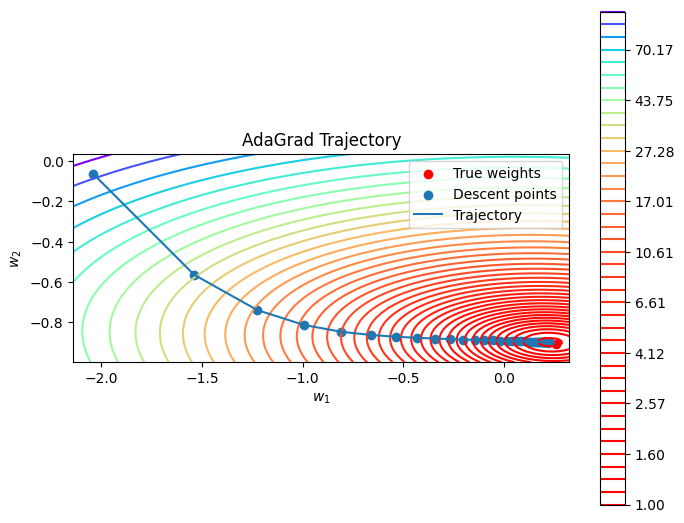

In [171]:
visualize_descent(w_list, X, Y, 
                  w_true=w_true,
                  title='AdaGrad Trajectory')

### RMSProp

**Идея:**  
RMSProp решает проблему затухания скорости обучения в AdaGrad за счёт использования экспоненциального скользящего среднего квадратов градиентов вместо их простой суммы.

**Обновление:**  
Обновляем экспоненциальное скользящее среднее:
$$
E[g^2]_t = \beta E[g^2]_{t-1} + (1-\beta) g_t^2,
$$
где $\beta$ — коэффициент затухания (обычно около 0.9). Затем обновляем параметры:
$$
w_{t+1} = w_t - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} \, g_t.
$$

In [174]:
np.random.seed(random_seed)
w = w_0.copy()
w_list = [w.copy()]
lr = 0.1
beta=0.9
epsilon=1e-8

E_grad2 = np.zeros_like(w)
for t in range(num_steps):
    grad = 2 * np.dot(X.T, (np.dot(X, w) - Y)) / n_objects
    E_grad2 = beta * E_grad2 + (1 - beta) * (grad**2)
    w -= lr * grad / (np.sqrt(E_grad2) + epsilon)
    w_list.append(w.copy())

w_list = np.array(w_list)

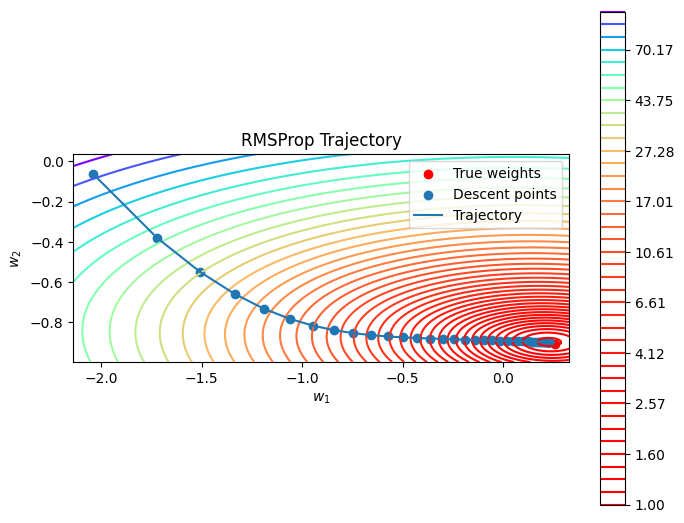

In [175]:
visualize_descent(w_list, X, Y, 
                  w_true=w_true,
                  title='RMSProp Trajectory')

### Adam (Adaptive Moment Estimation)

**Идея:**  
Adam сочетает в себе идеи импульсного метода и RMSProp. Он отслеживает как скользящее среднее градиентов, так и скользящее среднее квадратов градиентов. Также применяется коррекция смещения для обоих моментов.

**Обновление:**  
1. Обновляем экспоненциальное скользящее среднее градиентов:
   $$
   m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t.
   $$
2. Обновляем экспоненциальное скользящее среднее квадратов градиентов:
   $$
   v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2.
   $$
3. Коррекция смещения:
   $$
   \hat{m}_t = \frac{m_t}{1-\beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1-\beta_2^t}.
   $$
4. Обновление параметров:
   $$
   w_{t+1} = w_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \, \hat{m}_t.
   $$
   
Обычно выбирают $\beta_1 = 0.9$, $\beta_2 = 0.999$ и $\epsilon = 10^{-8}$.


In [180]:
np.random.seed(random_seed)
w = w_0.copy()
w_list = [w.copy()]
lr = 0.07
m = np.zeros_like(w)
v = np.zeros_like(w)
beta1=0.9
beta2=0.999
epsilon=1e-8

for t in range(1, num_steps + 1):
    grad = 2 * np.dot(X.T, (np.dot(X, w) - Y)) / n_objects
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad**2)
    m_hat = m / (1 - beta1**t)
    v_hat = v / (1 - beta2**t)
    w -= lr * m_hat / (np.sqrt(v_hat) + epsilon)
    w_list.append(w.copy())

w_list = np.array(w_list)

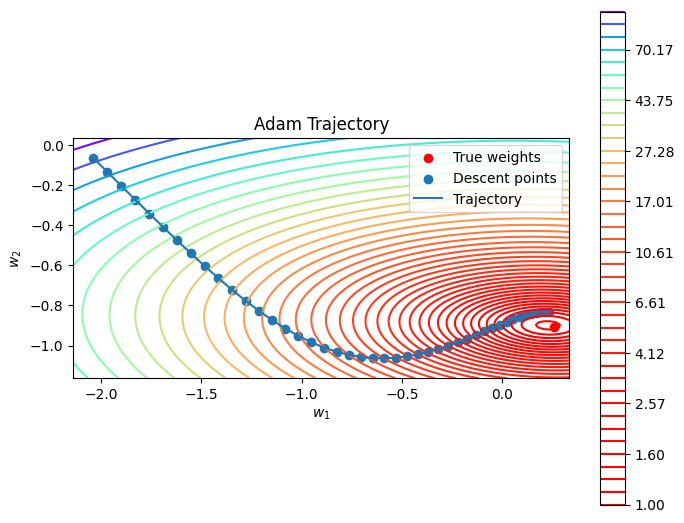

In [181]:
visualize_descent(w_list, X, Y,
                  w_true=w_true,
                  title='Adam Trajectory')

### Сравнение скорости сходимости
Наконец, важно сравнить скорость сходимости для полного и стохастического GD. Давайте сгенерируем случайный набор данных и построим график значения функции потерь по номеру итерации

In [129]:
n_features = 50
n_objects = 1000
num_steps = 500
batch_size = 10

w_true = np.random.uniform(-2, 2, n_features)

X = np.random.uniform(-10, 10, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 5, n_objects)

In [130]:
lr_sgd = 1e-3
lr_gd = 1e-3
w_sgd = np.random.uniform(-4, 4, n_features)
w_gd = w_sgd.copy()

residuals_sgd = [np.mean(np.power(np.dot(X, w_sgd) - Y, 2))]
residuals_gd = [np.mean(np.power(np.dot(X, w_gd) - Y, 2))]

In [131]:
for i in range(num_steps):
    lr = lr_gd / ((i + 1) ** 0.51)
    grad_gd = 2 * np.dot(X.T, (np.dot(X, w_gd) - Y)) / n_objects
    w_gd = w_gd - lr * grad_gd
    residuals_gd.append(np.mean((np.dot(X, w_gd) - Y) ** 2))

In [132]:
for i in range(num_steps * 5):
    lr = lr_sgd / ((i + 1) ** 0.51)
    sample = np.random.randint(n_objects, size=batch_size)
    grad_sgd = 2 * np.dot(X[sample].T, 
                          (np.dot(X[sample], w_sgd) - Y[sample])) / batch_size
    w_sgd = w_sgd - lr * grad_sgd
    residuals_sgd.append(np.mean((np.dot(X, w_sgd) - Y) ** 2))

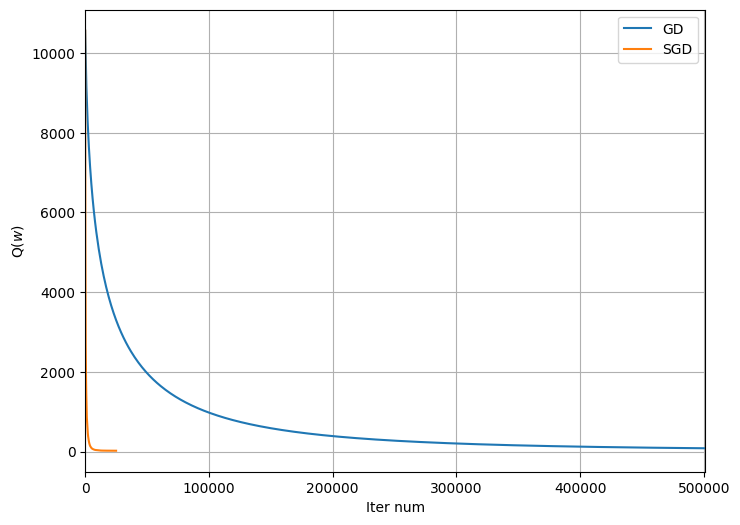

In [133]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(num_steps + 1) * n_objects, residuals_gd, label='GD')
plt.plot(np.arange(num_steps * 5 + 1) * batch_size, residuals_sgd, label='SGD')
plt.xlim((-1, (num_steps+1)*n_objects))
plt.legend()
plt.xlabel('Iter num')
plt.ylabel(r'Q($w$)')
plt.grid()
plt.show()

Как показано, SGD достигает оптимума в течение нескольких итераций. 

Обычно более крупные модели демонстрируют большие колебания значений функции потерь в процессе сходимости методов на основе стохастического градиента. На практике размер шага SGD может быть скорректирован для достижения лучшей скорости сходимости, и существует несколько методов, которые реализуют размер шага адаптивного градиентного спуска: AdaGrad, Adam, RMSProp и т. д.

### Дополнительно: Анализ нестабильности
Используя новую технику, давайте проанализируем поведение линейной регрессии в случае мультиколлинеарных признаков.

В случае (мульти-)коллинеарных признаков решение *нестабильно*. Давайте посмотрим на *число обусловленности* нашей матрицы:
$$\kappa(a) = \frac{\sigma_{\max}(A)}{\sigma_{\min}(A)}$$
где $\sigma _{\max }(A)$ и $\sigma _{\min }(A)$ — максимальные и минимальные сингулярные значения матрицы $A$ соответственно. Следовательно

In [95]:
def get_w_by_grad(X, Y, num_steps, w_0, lr):
    w = w_0.copy()

    for i in range(num_steps):
        w -= 2 * lr * np.dot(X.T, np.dot(X, w) - Y) / Y.shape[0]
    return w

def get_w_by_stoch_grad(X, Y, num_steps, w_0, lr_0, n_objects):
    w = w_0.copy()
    lr_0 = 0.45

    for i in range(num_steps):
        lr = lr_0 / ((i+1)**0.51)
        sample = np.random.randint(n_objects, size=batch_size)
        w -= 2 * lr * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / Y.shape[0]
    return w

def rmse(y_true, y_pred):
    return np.linalg.norm(y_true-y_pred)

In [96]:
lr = 1e-3
sgd_lr = 0.1
num_steps = 250
noise_eps_seq = np.logspace(-2, -6, 20)

w_0 = np.random.uniform(-2, 2, (n_features))

In [97]:
condition_numbers = []
vector_norms_list = []
rmse_list = []
results_list = []
for eps in noise_eps_seq:
    local_condition_numbers = []
    local_vector_norms_list = []
    local_rmse_list = []
    for i in range(50):
        X[:, -1] = 2 * (X[:, -2] + np.random.uniform(-eps, eps, X[:, -2].shape))

        a = np.linalg.eigvals(X.T.dot(X))
        local_condition_numbers.append(a.max() / a.min())

        w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
        w_star_grad = get_w_by_grad(X, Y, num_steps, w_0, lr)
        w_star_sgd = get_w_by_stoch_grad(X, Y, num_steps, w_0, sgd_lr, n_objects)
        local_vector_norms_list.append([
            np.linalg.norm(w_star),
            np.linalg.norm(w_star_grad), 
            np.linalg.norm(w_star_sgd),
        ])

        analytical_predict = X.dot(w_star)
        grad_predict = X.dot(w_star_grad)
        sgd_predict = X.dot(w_star_sgd)
        
        local_rmse_list.append([
            rmse(Y, analytical_predict),
            rmse(Y, grad_predict),
            rmse(Y, sgd_predict),
        ])
        
        results_list.append([w_star, w_star_grad, w_star_sgd])

    condition_numbers.append([np.mean(local_condition_numbers), np.std(local_condition_numbers)])
    vector_norms_list.append([
        np.mean(np.array(local_vector_norms_list), axis=0),
        np.std(np.array(local_vector_norms_list), axis=0),
    ])
    rmse_list.append(np.mean(np.array(local_rmse_list), axis=0))

condition_numbers = np.array(condition_numbers)
vector_norms_list = np.array(vector_norms_list)
rmse_list = np.array(rmse_list)

In [99]:
def visualise(mu, sigma, points, title=None, greater_than_zero=False, log_scale=False):
    if greater_than_zero:
        mu = np.clip(mu, 0, mu.max())
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    plt.plot(points, mu, "r", label="mean value")
    _x = np.concatenate((points, points[::-1]))
    _y = np.concatenate((
        [mu[i] - sigma[i] for i in range(len(points))], 
        [mu[i] + sigma[i] for i in range(len(points)-1, -1, -1)],
    ))
    if greater_than_zero:
        _y = np.clip(_y, 0, _y.max())
    plt.fill(_x, _y, fc='r', alpha=.2, ec=None, label='+- sigma range')
    
    if log_scale:
        ax.set_xscale('log')
        
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.grid()

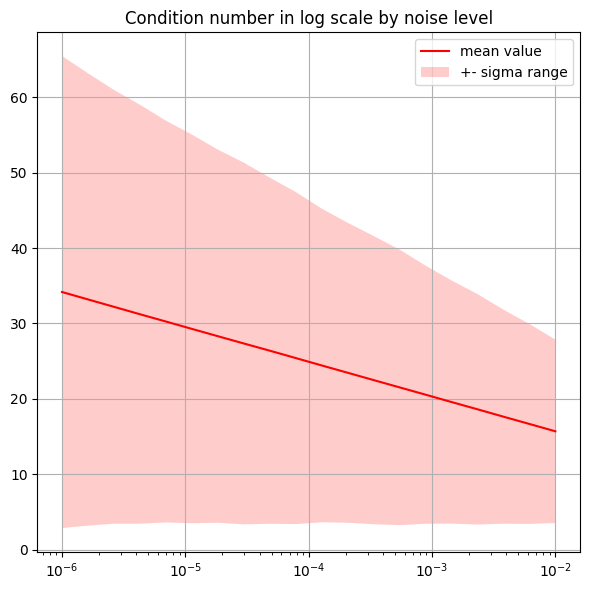

In [100]:
visualise(
    np.log(condition_numbers[:, 0]), 
    np.log(condition_numbers[:, 1]),
    noise_eps_seq, 
    title='Condition number in log scale by noise level',
    greater_than_zero=True,
    log_scale=True
)

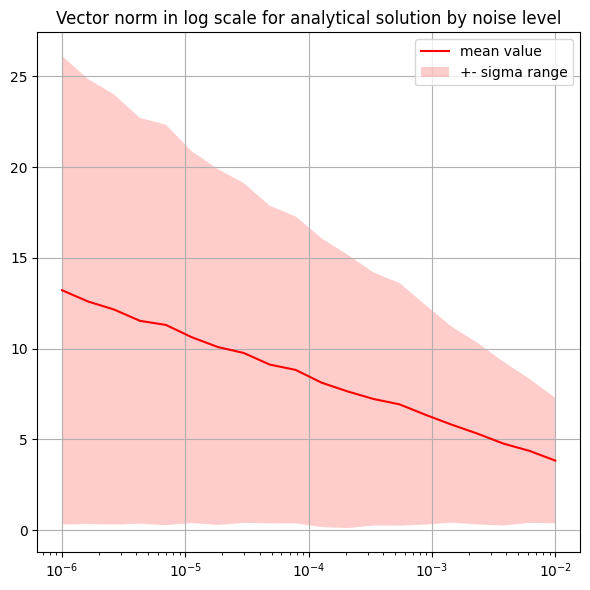

In [101]:
visualise(
    np.log(vector_norms_list[:, 0, 0]), 
    np.log(vector_norms_list[:, 1, 0]),
    noise_eps_seq, 
    title='Vector norm in log scale for analytical solution by noise level',
    greater_than_zero=True,
    log_scale=True
)

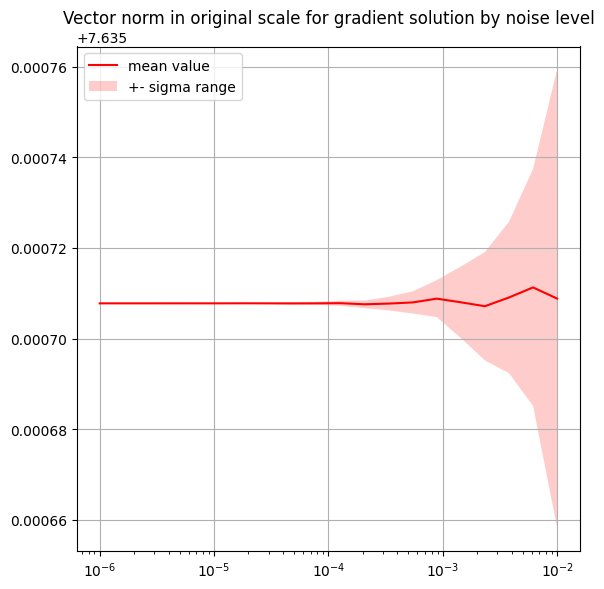

In [102]:
visualise(
    vector_norms_list[:, 0, 1], 
    vector_norms_list[:, 1, 1],
    noise_eps_seq, 
    title='Vector norm in original scale for gradient solution by noise level',
    greater_than_zero=True,
    log_scale=True
)

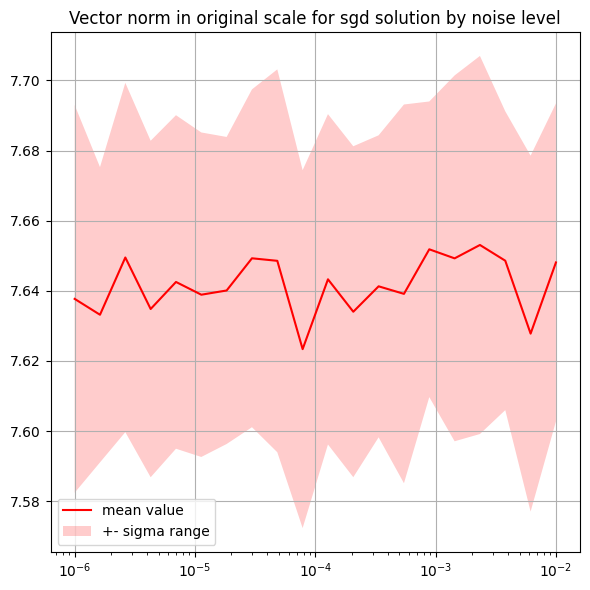

In [103]:
visualise(
    vector_norms_list[:, 0, 2], 
    vector_norms_list[:, 1, 2],
    noise_eps_seq, 
    title='Vector norm in original scale for sgd solution by noise level',
    greater_than_zero=True,
    log_scale=True
)

## Линейная регрессия "из коробки"

Наконец, давайте кратко рассмотрим реализованные версии линейной регрессии из sklearn. Основные классы:

* [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) — классическая линейная регрессия (*на самом деле, это просто `scipy.linalg.lstsq`, обернутая в класс sklearn `Predictor`) __аналитический__ решатель.
* [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) — линейная регрессия с регуляризацией L1.

* [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) — Линейная регрессия с регуляризацией L2.

Чтобы минимизировать любую другую функцию ошибки, вы можете использовать [SGDRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)

Давайте сравним скорость аналитических и градиентных решений из реализаций sklearn.

Будет `%%time` из IPython.

Для измерения качества будет использоваться оценка $R^2$. Он сравнивает нашу модель с моделью, всегда предсказывающей среднее $\mathbf{y}$:

$$R^2 = 1 - \frac{\sum_i (y_i - a(x_i))^2}{\sum_i (y_i - \overline{y}_i)^2}$$

![](img/mortal_combat.jpg)

In [104]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [105]:
n_features = 700
n_objects = 100000
num_steps = 150

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

In [106]:
%%time

lr = LinearRegression()
lr.fit(X, Y)
print(f'R2: {lr.score(X, Y)}')

R2: 0.9999686663565782
CPU times: total: 32.9 s
Wall time: 4.82 s


In [107]:
%%time

lr = Ridge(alpha=0.0, solver='sparse_cg')
lr.fit(X, Y)
print(f'R2: {lr.score(X, Y)}')

R2: 0.9999686639818677
CPU times: total: 4.41 s
Wall time: 1.3 s


## Собственная версия линейной регрессии

Давайте используем стандартные интерфейсы `sklearn` для реализации запечатанной версии нашей версии линейной регрессии с использованием SGD

Сначала нам нужно унаследовать базовые классы, затем реализовать 3 основных этапа жизни регрессора как методы:
- инициализация гиперпараметров - конструктор класса
- обучение параметров на известных объектах - метод `fit`
- оценка цели для неизвестных объектов - метод `predict`

In [108]:
from sklearn.base import BaseEstimator, RegressorMixin

In [109]:
class LinearRergessionSGD(BaseEstimator, RegressorMixin):
    '''LinearRergession with L2 regularization and SGD optimizer
    '''
    def __init__(self, C: float=1.0,
                 batch_size: int=25,
                 lr: float=1e-2,
                 num_steps: int=200) -> None:
        self.C = C
        self.batch_size = batch_size
        self.lr = lr
        self.num_steps = num_steps

    def fit(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)

        for i in range(self.num_steps):
            sample_indices = np.random.randint(n_objects, size=self.batch_size)
            w -= 2 * self.lr * np.dot(X[sample_indices].T, 
                                      np.dot(X[sample_indices], w) 
                                      - Y[sample_indices]) / self.batch_size

        self.w = w
        return self

    def predict(self, X):
        return X@self.w

In [110]:
n_features = 700
n_objects = 100000
num_steps = 150

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features)) * np.arange(n_features)
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [113]:
own_lr = LinearRergessionSGD().fit(x_train, y_train)
print(f'R2: {own_lr.score(x_test, y_test)}')

ValueError: Input contains NaN.

Что-то пошло не так. Что это может быть?

Во время нашего SGD мы столкнулись со слишком большими значениями для хранения в float.

Это приводит нас к нормализации признаков - масштабируем признаки.

In [114]:
from sklearn.preprocessing import StandardScaler

In [115]:
scaler = StandardScaler()
scaler.fit(x_train)
x_scaled = scaler.transform(x_train)

In [116]:
own_lr = LinearRergessionSGD().fit(x_scaled, y_train)

In [117]:
x_test_scaled = scaler.transform(x_test)

In [118]:
print(f'R2: {own_lr.score(x_test_scaled, y_test)}')

R2: 0.9970000638642463


Как вы помните мы не реализовали метод `score`. Но базовый класс `sklearn` предоставляет нам его уже реализованным (и некоторые другие).